ViT-based model using Transfer-Learning
---
#### Model: google/vit-base-patch16-224, descongelando las últimas 7 capas del encoder
#### Epochs: 30
#### Dataset: mages_3categories_balanced
#### Cambios:
- DropOut:
    - Clasificador 0.4
    - HiddenLayer 0.3
    - AttentionLayer 0.3 
- Learning Rate 1e-4    
- Weighted Loss

In [1]:
# Parámetros
_model = 'google/vit-base-patch16-224'
# path al checkpoint a cargar, None si no existe
_checkpoint = None
_output = 'SavedModels/ViT-base-patch16-224_G'  # path para guardar el modelo -> Revisar

_dataset = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_3categories_balanced'

# path para guardar el dataset con split
_dataset_split_path = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_3categories_balanced_augmented_V3_split'

# Si el dataset ya está separado en train, validation y test ->  _dataset_split=_dataset_split_path. 
# Si no está separado -> _dataset_split=None.
_dataset_split = None  

_batch_size = 32
_learning_rate = 1e-4
_epochs = 30  # Epochs a entrenar el modelo

# DropOut
_dp_clasificador = 0.4
_dp_hidden_layer = 0.3
_dp_attention_layer= 0.3

num_layers_to_unfreeze = 7  # Definir el número de capas a descongelar, None eoc

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from collections import Counter
from datasets import load_dataset, DatasetDict, load_from_disk,concatenate_datasets

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

import evaluate
from torchvision import transforms
from Utils import *

## Carga de datos

In [3]:
if _dataset_split is None:
    dataset = load_dataset(_dataset)
else:
    # Cargar el dataset previamente guardado
    dataset = load_from_disk(_dataset_split_path)

dataset

Resolving data files:   0%|          | 0/7504 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7504
    })
})

### Revisión de categorías

In [4]:
labels = dataset['train'].features['label'].names
print(len(labels),labels)

label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

3 ['calcificaciones', 'masas', 'no_encontrado']


#### Muestra de ejemplos

In [5]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
            
# show_samples(dataset['train'],rows=3,cols=5)

## Split Dataset

In [6]:
if _dataset_split is None:
    split_dataset = dataset['train'].train_test_split(test_size=0.2)
    eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)
    
    
    # Recombinar los splits 
    
    final_dataset = DatasetDict({
        'train': split_dataset['train'],
        'validation': eval_dataset['train'],
        'test': eval_dataset['test']
    })
    
else:
    final_dataset = dataset
final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6003
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 751
    })
})

### Extra Data Augmentation

In [7]:
# Definir transformaciones de Data Augmentation para el entrenamiento
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(10),                # Rotación aleatoria de ±10 grados
    transforms.RandomHorizontalFlip(),            # Flip horizontal aleatorio
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambios aleatorios de brillo, contraste, saturación y tono
])

def augment_images(batch):
    """Aplica transformaciones de Data Augmentation a las imágenes del batch."""
    augmented_images = []
    for img in batch['image']:
        # Convertir PIL Image a RGB
        img = img.convert('RGB')
        # Aplicar augmentations
        img = augmentation_transforms(img)
        augmented_images.append(img)
    batch['image'] = augmented_images
    return batch

if _dataset_split is None:
    # Aplicar Data Augmentation solo al conjunto de entrenamiento
    augmented_train = final_dataset['train'].map(augment_images, batched=True)
    augmented_validation = final_dataset['validation'].map(augment_images, batched=True)
    augmented_test = final_dataset['test'].map(augment_images, batched=True)
    
    
    # Concatenar el dataset original de entrenamiento con el aumentado
    # Esto duplica el tamaño del conjunto de entrenamiento con datos aumentados
    augmented_train = concatenate_datasets([final_dataset['train'], augmented_train])
    augmented_validation = concatenate_datasets([final_dataset['validation'], augmented_validation])
    augmented_test = concatenate_datasets([final_dataset['test'], augmented_test])
     # Recombinar los splits 
        
    final_dataset = DatasetDict({
        'train': augmented_train,
        'validation': augmented_validation,
        'test': augmented_test
    })
     # Guardar el dataset dividido
    final_dataset.save_to_disk(_dataset_split_path)

else:
    final_dataset = dataset
final_dataset

Map:   0%|          | 0/6003 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12006 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1502 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12006
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1502
    })
})

In [8]:
print('Número de imágenes por clases en cada split')
clases_split = pd.DataFrame(columns=['split', *labels])
for key in final_dataset:
    split = pd.DataFrame(final_dataset[key])
    num = split['label'].value_counts().sort_index()
    clases_split.loc[len(clases_split)] = [key, *num]
    #print(num.sort_index())
clases_split['total'] = clases_split[['calcificaciones', 'masas', 'no_encontrado']].sum(axis=1)
clases_split

Número de imágenes por clases en cada split


,split,calcificaciones,masas,no_encontrado,total
0,train,3930,4034,4042,12006
1,validation,518,490,492,1500
2,test,556,480,466,1502


## Preprocesamiento de las imágenes

In [13]:
processor = AutoImageProcessor.from_pretrained(_model, use_fast=True)
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels'] = batch['label']  # Las clases ya están en formato numérico
    return inputs

In [15]:
processed_dataset = final_dataset.with_transform(transforms)

### Data Collation

In [16]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Métricas de evaluación

In [17]:
import numpy as np
import evaluate

accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    print("Conteo de etiquetas reales:", Counter(labels))
    print("Conteo de predicciones:", Counter(predictions))
    
    precision_per_class = precision.compute(
    predictions=predictions, references=labels, average=None)
    print("Precision por clase:", precision_per_class, '\n')

    # Accuracy no requiere el parámetro average
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)['accuracy']
    
    # Las demás métricas sí requieren el parámetro average para multiclase
    precision_score = precision.compute(predictions=predictions, references=labels, average='macro')['precision']
    recall_score = recall.compute(predictions=predictions, references=labels, average='macro')['recall']
    f1_score = f1.compute(predictions=predictions, references=labels, average='macro')['f1']
    
    return {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score
    }

## Carga del modelo

In [18]:
# Clase personalizada que añade dropout antes de la capa final de clasificación
class CustomViTForImageClassification(ViTForImageClassification):
    def __init__(self, config):
        super().__init__(config)
        
        # Dropout adicional antes de la capa final
        self.additional_dropout = nn.Dropout(_dp_clasificador)  # Dropout antes del clasificador
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values)  # Obtenemos la salida del modelo ViT
        
        # Usamos el primer token [CLS] de la salida
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] está en la posición 0
        
        # Aplicamos dropout adicional antes de la clasificación
        pooled_output = self.additional_dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            # Asegúrate de que las etiquetas sean tipo long (para clasificación)
            class_weights = torch.tensor([1.0, 1.5, 1.0], dtype=torch.float32)  # Aumentar peso de "sospechoso"
            loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(self.device))  # Enviar los pesos al dispositivo
            loss = loss_fn(logits, labels)
        
        return (loss, logits) if loss is not None else logits

# Configuramos el modelo base con Dropout en las capas internas del ViT
model = CustomViTForImageClassification.from_pretrained(
    _model,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    hidden_dropout_prob=_dp_hidden_layer,  # Dropout en las capas internas del modelo
    attention_probs_dropout_prob=_dp_attention_layer,  # Dropout en las capas de atención
    ignore_mismatched_sizes = True
)

Some weights of CustomViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Arquitectura del modelo

In [19]:
model

CustomViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear

### Congelar todas las capas, menos el clasificador

In [20]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [21]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,800,963 | trainable_params = 2,307


### Descongelar capas del encoder para fine-tuning

In [22]:
# Obtener el número total de capas en el encoder
num_total_layers = len(list(model.vit.encoder.layer))  # Debería ser 24 para ViT-Large, 12 para ViT-base
print(num_total_layers)

12


In [23]:
# Si se descongelan capas
if num_layers_to_unfreeze is not None:
    # Calcular el índice a partir del cual descongelar
    unfreeze_from = num_total_layers - num_layers_to_unfreeze
    
    # Iterar sobre todas las capas del encoder
    for idx, layer in enumerate(model.vit.encoder.layer):
        if idx >= unfreeze_from:
            # Descongelar esta capa
            for param in layer.parameters():
                param.requires_grad = True
        else:
            # Congelar esta capa
            for param in layer.parameters():
                param.requires_grad = False


In [24]:
# Mostrar el número total de parámetros y los entrenables después de descongelar
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Después de descongelar las últimas {num_layers_to_unfreeze} capas:")
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

Después de descongelar las últimas 7 capas:
Total de parámetros: 85,800,963
Parámetros entrenables: 49,617,411


In [25]:
# Revisión de trainable por capa
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    #print(f"{name}: {status}")

## Training

In [26]:
training_args = TrainingArguments(
    output_dir=_output,
    per_device_train_batch_size=_batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=_epochs,  # Epochs a entrenar -> Revisar
    learning_rate=_learning_rate,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    metric_for_best_model="precision",  # Métrica para seleccionar el mejor modelo
    greater_is_better=True  # True si la métrica debe aumentar (ej., accuracy)
)

In [27]:
# Crear el callback de early stopping
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Número de epochs sin mejora permitida
    early_stopping_threshold=0.0001  # Mejora mínima necesaria
)


In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,
    #callbacks=[early_stopping_callback]  # Añadir el callback
)

In [29]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS enabled")

MPS enabled


In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.822700,0.797721,0.613333,0.598337,0.618285,0.596488
2,0.769500,0.770583,0.641333,0.629464,0.645057,0.629190
3,0.760900,0.798774,0.656000,0.655304,0.663528,0.632631
4,0.727500,0.730944,0.652000,0.643045,0.655683,0.639077
5,0.718700,0.737290,0.665333,0.659285,0.667858,0.661526
6,0.703000,0.726943,0.676000,0.670116,0.678395,0.671334
7,0.690600,0.713606,0.681333,0.676618,0.684445,0.671493
8,0.682400,0.662352,0.693333,0.688240,0.696012,0.685276
9,0.641200,0.686692,0.702667,0.702242,0.704326,0.693251
10,0.610900,0.724113,0.697333,0.696951,0.701946,0.686638


Conteo de etiquetas reales: Counter({np.int64(1): 262, np.int64(2): 248, np.int64(0): 240})
Conteo de predicciones: Counter({np.int64(2): 336, np.int64(0): 240, np.int64(1): 174})
Precision por clase: {'precision': array([0.60833333, 0.52298851, 0.66369048])} 

Conteo de etiquetas reales: Counter({np.int64(1): 262, np.int64(2): 248, np.int64(0): 240})
Conteo de predicciones: Counter({np.int64(2): 325, np.int64(0): 226, np.int64(1): 199})
Precision por clase: {'precision': array([0.63716814, 0.55276382, 0.69846154])} 

Conteo de etiquetas reales: Counter({np.int64(1): 262, np.int64(2): 248, np.int64(0): 240})
Conteo de predicciones: Counter({np.int64(2): 313, np.int64(0): 310, np.int64(1): 127})
Precision por clase: {'precision': array([0.59032258, 0.65354331, 0.72204473])} 

Conteo de etiquetas reales: Counter({np.int64(1): 262, np.int64(2): 248, np.int64(0): 240})
Conteo de predicciones: Counter({np.int64(2): 334, np.int64(0): 225, np.int64(1): 191})
Precision por clase: {'precision':

TrainOutput(global_step=12690, training_loss=0.5788764526751964, metrics={'train_runtime': 13166.6922, 'train_samples_per_second': 30.775, 'train_steps_per_second': 0.964, 'total_flos': 3.1400810544739156e+19, 'train_loss': 0.5788764526751964, 'epoch': 30.0})

In [ ]:
trainer.save_model()

### Evaluación del modelo

In [31]:
trainer.evaluate(processed_dataset['test'])

Conteo de etiquetas reales: Counter({np.int64(0): 259, np.int64(1): 250, np.int64(2): 242})
Conteo de predicciones: Counter({np.int64(2): 317, np.int64(0): 261, np.int64(1): 173})
Precision por clase: {'precision': array([0.75095785, 0.76300578, 0.69716088])} 



{'eval_loss': 0.9023119211196899,
 'eval_accuracy': 0.7310252996005326,
 'eval_precision': 0.7370415060112361,
 'eval_recall': 0.7326599657508748,
 'eval_f1': 0.7228857678140211,
 'eval_runtime': 14.5144,
 'eval_samples_per_second': 51.742,
 'eval_steps_per_second': 6.476,
 'epoch': 30.0}

## Inferencia en conjunto de test 

In [32]:
samples = final_dataset['test']
processed_samples = samples.with_transform(transforms)
predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # labels predichas

Conteo de etiquetas reales: Counter({np.int64(0): 259, np.int64(1): 250, np.int64(2): 242})
Conteo de predicciones: Counter({np.int64(2): 317, np.int64(0): 261, np.int64(1): 173})
Precision por clase: {'precision': array([0.75095785, 0.76300578, 0.69716088])} 



In [ ]:
show_predictions(rows=5,cols=5, samples_=samples, predictions_=predictions, id2label_=id2label)

### Matriz de confusión

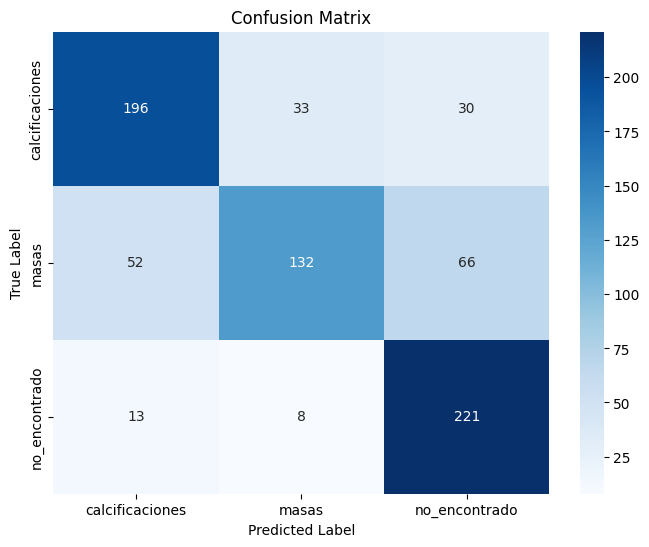

In [33]:
confusion_matrix(samples_=samples, predictions_=predictions, class_names=labels)

## Iterar por más epochs ❌

In [ ]:
trainer.args.num_train_epochs = 30  # Para entrenar hasta la época 20
trainer.train(resume_from_checkpoint=_checkpoint)

In [ ]:
trainer.save_model()

In [ ]:
trainer.evaluate(processed_dataset['test'])

In [ ]:
confusion_matrix(samples_=samples, predictions_=predictions)